# Comparison between Hammurabi and HamX

This notebook serves as a simple way to compare observables between Hammurabi and Hammurabi X to look for differences and see how they compare to the expected changes. The following blocks will set up and run hammurabi/X with the same settings so that any differences in the sync maps are due to changes in the new version, and not differences in parameters.

In [2]:
import sys # import all dependencies
sys.path.append('/Users/tjtaylo2/Software/hammurabi_x/hamx/src/hampyx') # path to hamx files 
sys.path.append('/Users/tjtaylo2/Software/hammurabi/hammurabi/hampy') # path to hammurabi files
import hampy
import hampyx_class as hampyx
from view_field import view_field
import matplotlib
from pylab import cm
%matplotlib inline
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
#  Healpy's mollview seems to change color tables on different systems
#   which is annoying.  Set it explicitly:
cmap=cm.get_cmap('jet')
cmap.set_under('w')

The input for mod_par and for changing parameters at call() is the same, with what I've called a keychain. 

The form of this input is [['path','to','parameter'],'target tag','value to give'], but this can be changed if it needs to be more clear. 

If you have multiple options with the same tag, you can use the slct option for mod_par to select a specific parameter to change (i.e. when you have two sync frequencies).

The choices for changed parameters include unused options and changes made to make the runs of hammurabi and hamx as similar as possible. Both codes are run with a non-physical GMF featuring several shells of magnetic intensity, a simple constant thermal electron field and a constant CRE density.

In [71]:
# run hammurabi with some custom parameters set, including reading 
# in the TE grid in as doubles and setting the working directory
ham = hampy.Hampy(working_directory='ham.out', hammurabi_path='/Users/tjtaylo2/Software/hammurabi/hammurabi/run/hammurabi.TE_float')
print(
    ham.call(custom_parameters= {
                                 'C1_hr':'100', # scale radius/height for cosmic rays,
                                 'C1_hz':'100', #     set to be very large
                                 'B_field_nx':'200',
                                 'B_field_ny':'200',
                                 'B_field_nz':'200',
                                 'B_field_type':'6',         # External field file
                                 'B_field_coherent_inp':'../../../hammurabi/hammurabi/unit_test/inputs/box_radio_loops.bin',
                                 'B_field_ec':'T',           # Center the box on the observer ("earth centric")
                                 'B_field_inp_type':'double',
                                 
                                 'TE_constant_pccm':'0.',   # constant TE field
                                 'do_sync_emission':'T','do_dust':'T',
                                 'max_radius':'7', # large integration radius
                                 'B_field_lx':'40',
                                 'B_field_ly':'40',
                                 'B_field_lz':'8',
        
                                 'SunPosX':'0',
                                })
)
ham_maps = ham.get_observables()

.......................0


In [6]:
# run hamx with some changed parameters

hamx = hampyx.Hampy(custom_parameters = 'params_template.xml',working_directory = 'test.out')
hamx.mod_par([['Obsout','Sync'],'filename','./test.out/iqu_sync_23.fits'],slct=['freq','23'])
#hamx.mod_par([['Obsout','Sync'],'filename','./test.out/iqu_sync_1.4.fits'],slct=['freq','1.4'])
#hamx.mod_par([['Obsout','Sync'],'cue','0'],slct=['freq','1.4'])

print(
hamx.call(keychain=[
                   [['Grid','SunPosition','x'],'-8.5'], 
    
                   [['Grid','Shell','gc_r_max'],'50'], # large integration radius
                   [['Grid','Shell','gc_z_max'],'999'], # and integration height
                   [['Grid','Shell','ec_r_max'],'7'], 
    
                   [['Grid','Box_GMF','nx'],'value','200'],
                   [['Grid','Box_GMF','ny'],'value','200'], # matching size of GMF binary file
                   [['Grid','Box_GMF','nz'],'value','200'],
    
                   [['Grid','Box_GMF','x_min'],'-20'],
                   [['Grid','Box_GMF','x_max'],'20'],
                   [['Grid','Box_GMF','y_min'],'-20'],
                   [['Grid','Box_GMF','y_max'],'20'],
                   [['Grid','Box_GMF','z_min'],'-4'],
                   [['Grid','Box_GMF','z_max'],'4'],
    
                   [['FreeElectron','Regular','Verify','n0'],'0.'], # constant free electron (TE) density 
                     
                   [['Grid','Shell','nside_sim'],'value','128'], 
                   [['Grid','Box_FE','nx'],'value','256'],
                   [['Grid','Box_FE','ny'],'value','256'],
                   [['Grid','Box_FE','nz'],'value','64'],
                    
                   [['Fieldout','breg_grid'],'filename','../../../hammurabi/hammurabi/unit_test/inputs/box_radio_loops.bin'], 
                   [['Fieldout','breg_grid'],'read','1'], # read in magnetic field model
                   [['Fieldout','breg_grid'],'write','0'],
    
                   #[['Fieldout','fereg_grid'],'filename','../../../hammurabi/hammurabi/unit_test/inputs/box_TE_loops.bin'], 
                   [['Fieldout','fereg_grid'],'read','0'],
                   [['Fieldout','fereg_grid'],'write','0'],
    
                   [['Fieldout','cre_grid'],'write','0'],
                   [['Fieldout','cre_grid'],'filename','./test.out/cre.bin'],
                
                   [['Obsout','DM'],'filename','./test.out/dm.fits'],
                   [['Obsout','Faraday'],'filename','./test.out/fd.fits'],
                   
                   [['MagneticField','Regular'],'type','WMAP'],
                   [['FreeElectron','Regular'],'type','Verify'],
                   [['CRE'],'type','Verify'],
                    
                   # match CRE parameters to the defaults in hammurabi
                   [['CRE','Verify','alpha'],'3.0'], #3.0
                   [['CRE','Verify','r0'],'1000.0'], #1000.0
                   [['CRE','Verify','E0'],'20.6'], #20.6
                   [['CRE','Verify','j0'],'.25'] #.0217
                   ])
)
hamx_maps = hamx.get_obs()
np.save('test',hamx_maps['Sync']['I'])

............

0


To explore the tree of the xml parameter file, use the hammurabiX method "get_ele()". The input is an array, with a list of selections within the xml hierarchy to go down to the desired level and pick out the selected parameter, working in the same vein as a path to a file in unix. This will show the tags and attributes of different parameters. An example of a tag would be "read" for the parameter "fereg_grid" under the section "FieldOut" in the parameter file. The attribute for this tag would be either a boolean "1" or a "0". Other parameters have different expected tags: for example, some tags such as "filename" may be expecting a string.

In [3]:
hamx.get_ele(['MagneticField','Regular','Jaffe'],opts='All')

MagneticField
|--> Regular {'cue': '1', 'type': 'WMAP'}
|--> Random {'cue': '0', 'seed': '0', 'type': 'Local'}
Regular
|---> WMAP {}
|---> Jaffe {}
|---> Verify {}
Jaffe
|----> quadruple {'cue': '0'}
|----> bss {'cue': '0'}
|----> disk_amp {'value': '0.167'}
|----> disk_z0 {'value': '0.1'}
|----> halo_amp {'value': '1.38'}
|----> halo_z0 {'value': '3.0'}
|----> r_inner {'value': '0.5'}
|----> r_scale {'value': '20'}
|----> r_peak {'value': '0'}
|----> ring {'cue': '0'}
|----> bar {'cue': '1'}
|----> ring_amp {'value': '0.023'}
|----> ring_r {'value': '5.0'}
|----> bar_amp {'value': '0.023'}
|----> bar_a {'value': '5.0'}
|----> bar_b {'value': '3.0'}
|----> bar_phi0 {'value': '45.0'}
|----> arm_num {'value': '4'}
|----> arm_r0 {'value': '7.1'}
|----> arm_z0 {'value': '0.1'}
|----> arm_phi1 {'value': '70'}
|----> arm_phi2 {'value': '160'}
|----> arm_phi3 {'value': '250'}
|----> arm_phi4 {'value': '340'}
|----> arm_amp1 {'value': '2'}
|----> arm_amp2 {'value': '0.133'}
|----> arm_amp3 {'v

The next few blocks show examples of the format of hamx_maps (a nested dict so that each freq has its own dictionary for I Q U and other data) and the syntax to look at the xml parameters and structure.

In [5]:
# if only one Sync frequency is turned on, the nested dict will not have the ['freq'] level. So to look 
# at the Q array for example, you would do hamx_maps['Sync']['Q'], rather than specifying the freq also.

print hamx_maps['Sync']['23']['P']

[3431636.45703814 3431636.45703814 3431636.45703814 ... 3431636.45703799
 3431636.45703799 3431636.45703799]


In [6]:
ham.get_params()

{'B_field_coherent_inp': '../../../hammurabi/hammurabi/unit_test/inputs/box_radio_loops.bin',
 'B_field_do_random': 'F',
 'B_field_ec': 'F',
 'B_field_inp_type': 'double',
 'B_field_lx': '40',
 'B_field_ly': '40',
 'B_field_lz': '8',
 'B_field_nx': '200',
 'B_field_ny': '200',
 'B_field_nz': '200',
 'B_field_seed': '1486647502',
 'B_field_type': '6',
 'B_ran_mem_lim': '4',
 'C1_hr': '100',
 'C1_hz': '100',
 'TE_constant_pccm': '0.',
 'TE_grid_filename': '/Users/tjtaylo2/Software/hammurabi/hammurabi/hampy/test/negrid_n400.bin',
 'TE_nx': '400',
 'TE_ny': '400',
 'TE_nz': '80',
 'do_dm': 'F',
 'do_dust': 'T',
 'do_ff': 'F',
 'do_rm': 'T',
 'do_sync_emission': 'T',
 'do_tau': 'F',
 'max_radius': '40',
 'obs_DM_file_name': '/Users/tjtaylo2/Software/hammurabi_x/hamx/work/ham.out/dm.fits',
 'obs_NSIDE': '128',
 'obs_RM_file_name': '/Users/tjtaylo2/Software/hammurabi_x/hamx/work/ham.out/rm.fits',
 'obs_dust_file_name': '/Users/tjtaylo2/Software/hammurabi_x/hamx/work/ham.out/IQU_dust.fits',
 '

In [7]:
hamx.get_ele(['MagneticField','Regular','Verify'],'All') # the 'All' option shows the tree at each level

MagneticField
|--> Regular {'cue': '1', 'type': 'WMAP'}
|--> Random {'cue': '0', 'seed': '0', 'type': 'Local'}
Regular
|--> WMAP {}
|--> Jaffe {}
|--> Verify {}
Verify
|--> b0 {'value': '2.0'}
|--> l0 {'value': '0'}
|--> r {'value': '10'}


Use healpy's mollview() function to look at the arrays generated from the produced .fits files. The values for hamx are scaled by 10^-12 due to the difference in units used. Hammurabi uses uG while the new version assumes Gauss, and as syncrotron radiation goes as B^2, a factor of 10^-12 is necessary for the scales to be the same. The morphology, however, should be the same regardless of the scaling.

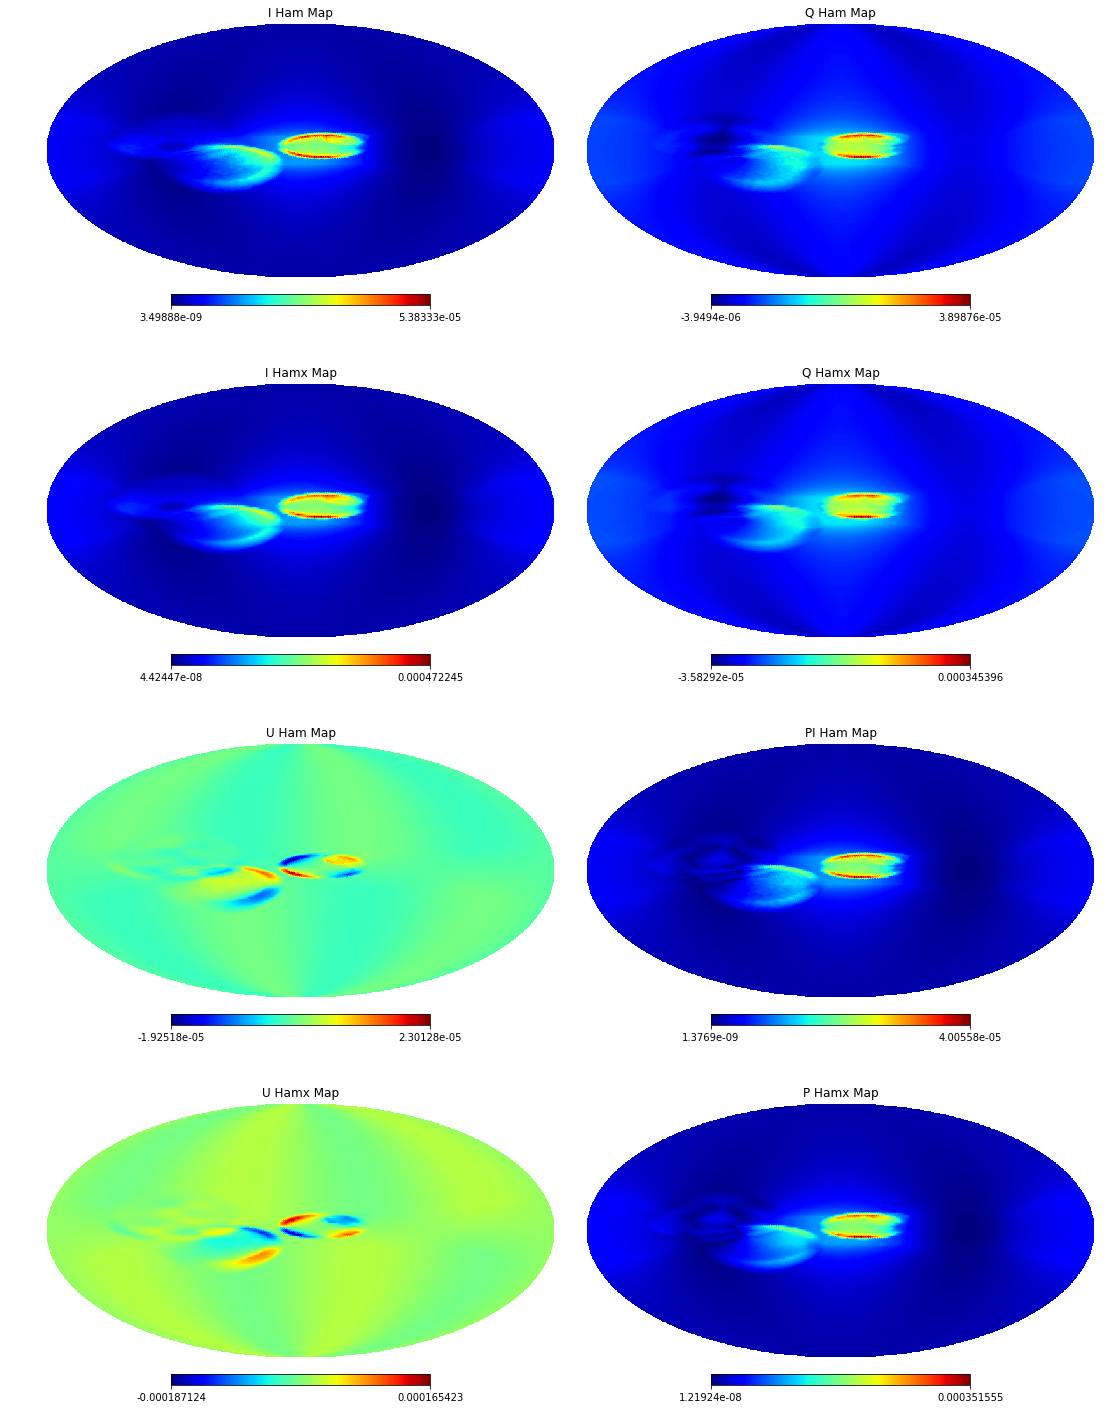

In [8]:
matplotlib.rcParams['figure.figsize'] = (15.0, 20.0)
hp.mollview(ham_maps['Is'],title = 'I Ham Map',sub=(4,2,1),cmap=cmap)
hp.mollview(ham_maps['Qs'],title = 'Q Ham Map',sub=(4,2,2),cmap=cmap)
hp.mollview(ham_maps['Us'],title = 'U Ham Map',sub=(4,2,5),cmap=cmap)
hp.mollview(ham_maps['PIs'],title = 'PI Ham Map',sub=(4,2,6),cmap=cmap)
hp.mollview(1e-12*hamx_maps['Sync']['23']['I'],title = 'I Hamx Map',sub=(4,2,3),cmap=cmap)
hp.mollview(1e-12*hamx_maps['Sync']['23']['Q'],title = 'Q Hamx Map',sub=(4,2,4),cmap=cmap)
hp.mollview(1e-12*hamx_maps['Sync']['23']['U'],title = 'U Hamx Map',sub=(4,2,7),cmap=cmap)
hp.mollview(1e-12*hamx_maps['Sync']['23']['P'],title = 'P Hamx Map',sub=(4,2,8),cmap=cmap)

To compare the two, we can look at difference maps normalized by their variance -- in this way, we will be focusing on the morphologies rather than the absolute scaling.

4.276661372772953e-05
3.597494421332937e-05
4.900612662584148e-06
3.9830311594198885e-06
0.09486479425535527


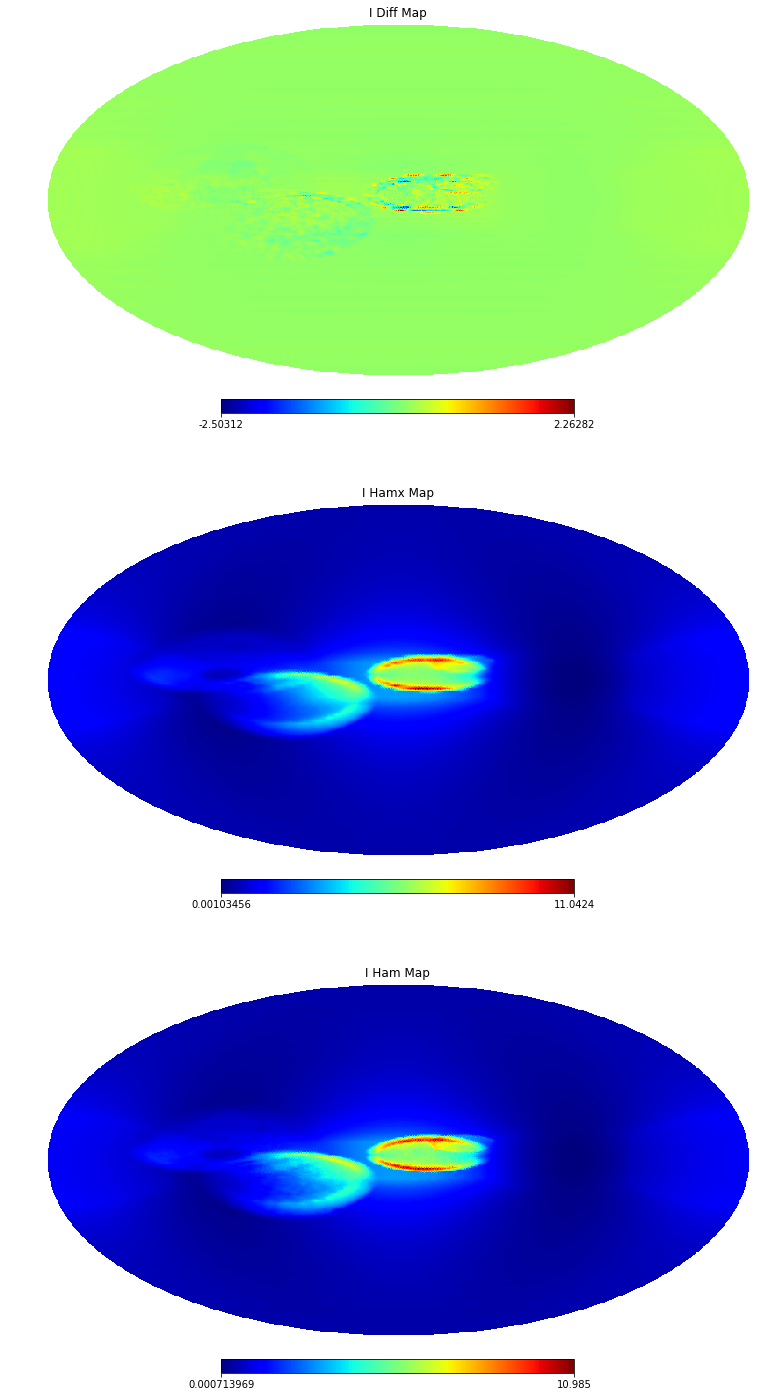

In [9]:
# difference map for I

hamx_Ivar=np.sqrt((hamx_maps['Sync']['23']['I']).var())
hamx_Iavg=np.average((hamx_maps['Sync']['23']['I']))

ham_Ivar=np.sqrt((ham_maps['Is']).var())
ham_Iavg=np.average((ham_maps['Is']))

print 1e-12*hamx_Ivar # units are 1e12 times larger than ham's units:
print 1e-12*hamx_Iavg

print ham_Ivar
print ham_Iavg

print np.sqrt((hamx_maps['Sync']['23']['I']/hamx_Iavg - ham_maps['Is']/ham_Iavg).var())
# this is intended to be a normalized measure of how different these maps are:
# close to zero implies small percentage differences between the two, and vice versa

matplotlib.rcParams['figure.figsize'] = (10.0, 20.0)
matplotlib.rcParams.update({'font.size': 10})
hp.mollview(hamx_maps['Sync']['23']['I']/hamx_Ivar-ham_maps['Is']/ham_Ivar,title = 'I Diff Map',cmap=cmap,sub=(3,1,1))
hp.mollview(hamx_maps['Sync']['23']['I']/hamx_Ivar,title = 'I Hamx Map',cmap=cmap,sub=(3,1,2))
hp.mollview(ham_maps['Is']/ham_Ivar,title = 'I Ham Map',cmap=cmap,sub=(3,1,3))


30756552.607955676
24421445.13947429
16977886.033498395
22613621.304698348
3.4635715122992218e-06
2.7314667132124904e-06
1.9479300315365007e-06
2.544151134247316e-06
0.051520284289135146
0.06262216887351686
1.9976078426334214
0.04982585976044252


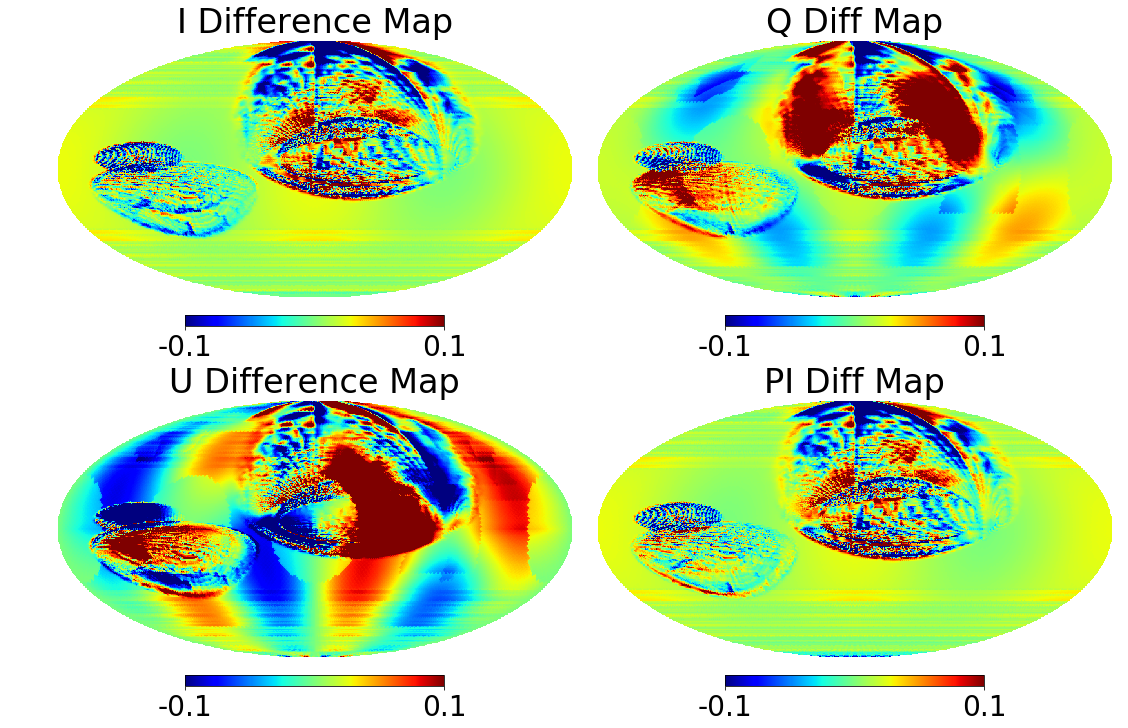

In [72]:
# set of difference maps -- lets look at all four

hamx_Ivar=np.sqrt((hamx_maps['Sync']['23']['I']).var())
hamx_Qvar=np.sqrt((hamx_maps['Sync']['23']['Q']).var())
hamx_Uvar=np.sqrt((hamx_maps['Sync']['23']['U']).var())
hamx_Pvar=np.sqrt((hamx_maps['Sync']['23']['P']).var())

ham_Ivar=np.sqrt((ham_maps['Is']).var())
ham_Qvar=np.sqrt((ham_maps['Qs']).var())
ham_Uvar=np.sqrt((ham_maps['Us']).var())
ham_Pvar=np.sqrt((ham_maps['PIs']).var())

print hamx_Ivar
print hamx_Qvar
print hamx_Uvar
print hamx_Pvar

print ham_Ivar
print ham_Qvar
print ham_Uvar
print ham_Pvar


print np.sqrt((hamx_maps['Sync']['23']['I']/hamx_Ivar - ham_maps['Is']/ham_Ivar).var())
print np.sqrt((hamx_maps['Sync']['23']['Q']/hamx_Qvar - ham_maps['Qs']/ham_Qvar).var())
print np.sqrt((hamx_maps['Sync']['23']['U']/hamx_Uvar - ham_maps['Us']/ham_Uvar).var())
print np.sqrt((hamx_maps['Sync']['23']['P']/hamx_Pvar - ham_maps['PIs']/ham_Pvar).var())

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
matplotlib.rcParams.update({'font.size': 28})
hp.mollview(hamx_maps['Sync']['23']['I']/hamx_Ivar-ham_maps['Is']/ham_Ivar,sub=(2,2,1),title = 'I Difference Map',cmap=cmap,min=-0.1,max=0.1)
#hp.visufunc.graticule() # this adds the lines of lattitude and longitude
hp.mollview(hamx_maps['Sync']['23']['Q']/hamx_Qvar-ham_maps['Qs']/ham_Qvar,sub=(2,2,2),title = 'Q Diff Map',cmap=cmap,min=-0.1,max=0.1)
hp.mollview(hamx_maps['Sync']['23']['U']/hamx_Uvar+ham_maps['Us']/ham_Uvar,sub=(2,2,3),title = 'U Difference Map',cmap=cmap,min=-0.1,max=0.1)
hp.mollview(hamx_maps['Sync']['23']['P']/hamx_Pvar-ham_maps['PIs']/ham_Pvar,sub=(2,2,4),title = 'PI Diff Map',cmap=cmap,min=-0.1,max=0.1)


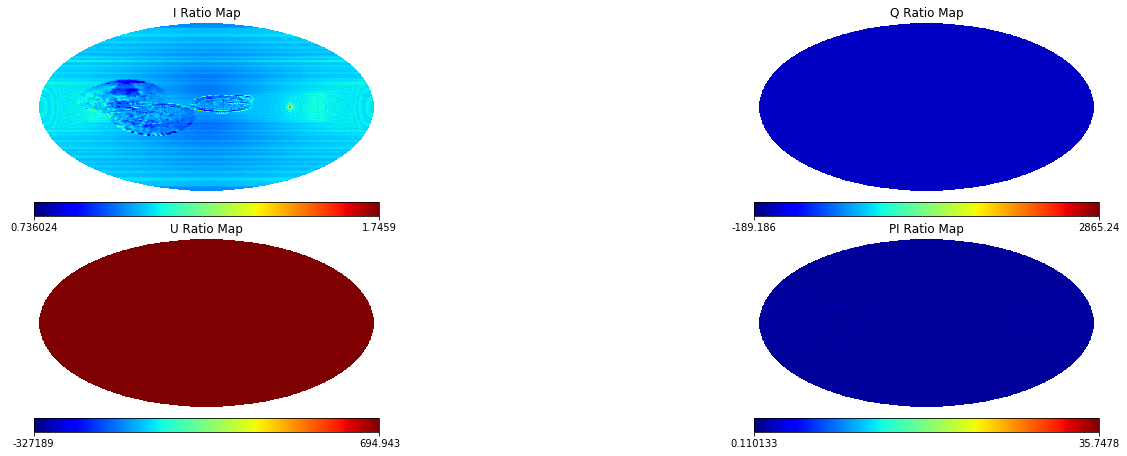

In [11]:
# set of ratio maps: keep in mind the difference in units (uG and G)
# when comparing normalized values

hamx_Ivar=np.sqrt((hamx_maps['Sync']['23']['I']).var())
hamx_Qvar=np.sqrt((hamx_maps['Sync']['23']['Q']).var())
hamx_Uvar=np.sqrt((hamx_maps['Sync']['23']['U']).var())
hamx_Pvar=np.sqrt((hamx_maps['Sync']['23']['P']).var())

ham_Ivar=np.sqrt((ham_maps['Is']).var())
ham_Qvar=np.sqrt((ham_maps['Qs']).var())
ham_Uvar=np.sqrt((ham_maps['Us']).var())
ham_Pvar=np.sqrt((ham_maps['PIs']).var())

matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
matplotlib.rcParams.update({'font.size': 10})
hp.mollview((hamx_maps['Sync']['23']['I']/hamx_Ivar)/(ham_maps['Is']/ham_Ivar),sub=(2,2,1),title = 'I Ratio Map',cmap=cmap)
hp.mollview((hamx_maps['Sync']['23']['Q']/hamx_Qvar)/(ham_maps['Qs']/ham_Qvar),sub=(2,2,2),title = 'Q Ratio Map',cmap=cmap)
hp.mollview((hamx_maps['Sync']['23']['U']/hamx_Uvar)/(ham_maps['Us']/ham_Uvar),sub=(2,2,3),title = 'U Ratio Map',cmap=cmap)
hp.mollview((hamx_maps['Sync']['23']['P']/hamx_Pvar)/(ham_maps['PIs']/ham_Pvar),sub=(2,2,4),title = 'PI Ratio Map',cmap=cmap)



## Faraday Rotation

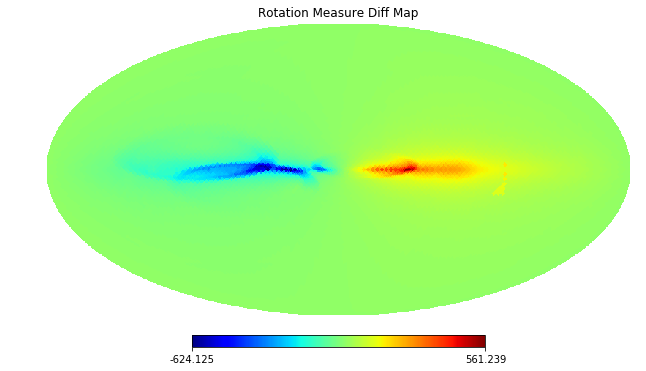

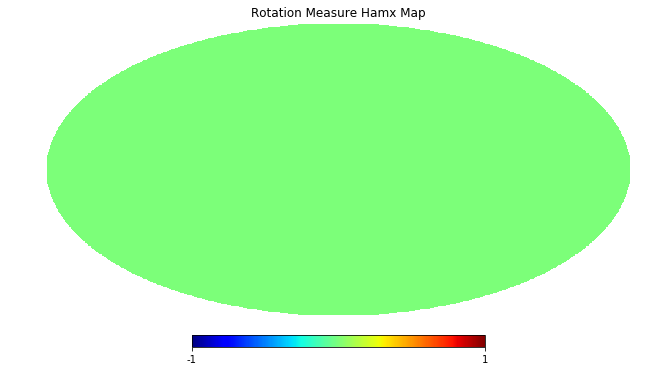

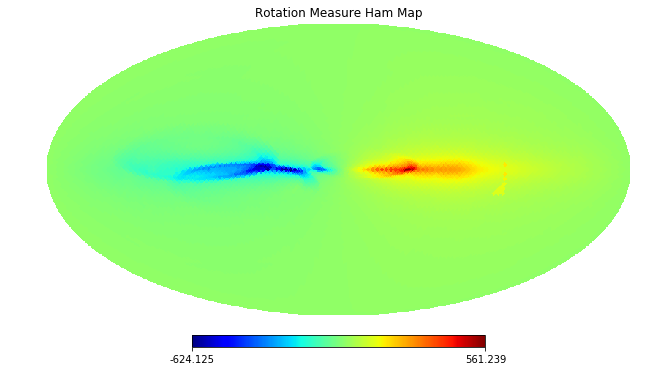

In [12]:
# Same look at the Faraday rotation
hp.mollview(ham_maps['RM']-hamx_maps['Fd'],cmap=cmap,title='Rotation Measure Diff Map')
hp.mollview(hamx_maps['Fd'],cmap=cmap,title='Rotation Measure Hamx Map')
hp.mollview(ham_maps['RM'],cmap=cmap,title='Rotation Measure Ham Map')

## DM

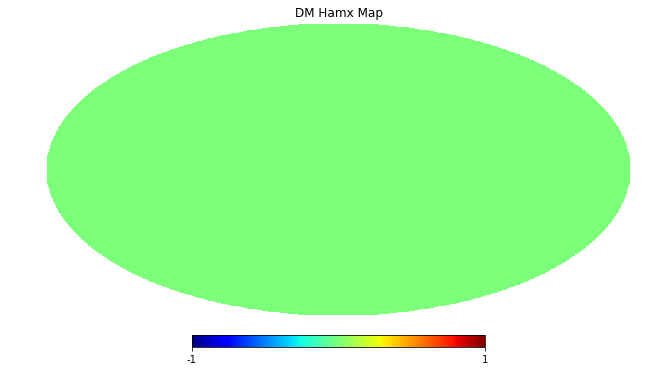

In [13]:
hp.mollview(hamx_maps['DM'],title = 'DM Hamx Map',cmap=cmap)

## Magnetic Field

{'origin': [20, 20, 4], 'slices': [32, 256, 256], 'xrange': None, 'bskip': 25, 'scalar': False, 'bcolor': 'k', 'font': 20, 'unit': '[kpc]', 'fcodeB': '{:.2f}', 'yrange': None, 'title': None, 'label': '|B| [uG]', 'Ldims': [40, 40, 8], 'dtype': 'double', 'crange': None, 'infile': './test.out/hamx_breg.bin', 'norm': 1.0, 'outfile': None, 'Ndims': [512, 512, 64], 'cmap': 'jet', 'figsize': None, 'bconst': False, 'bscale': 0.05, 'zrange': None, 'fcodeL': '{:.2f}'}


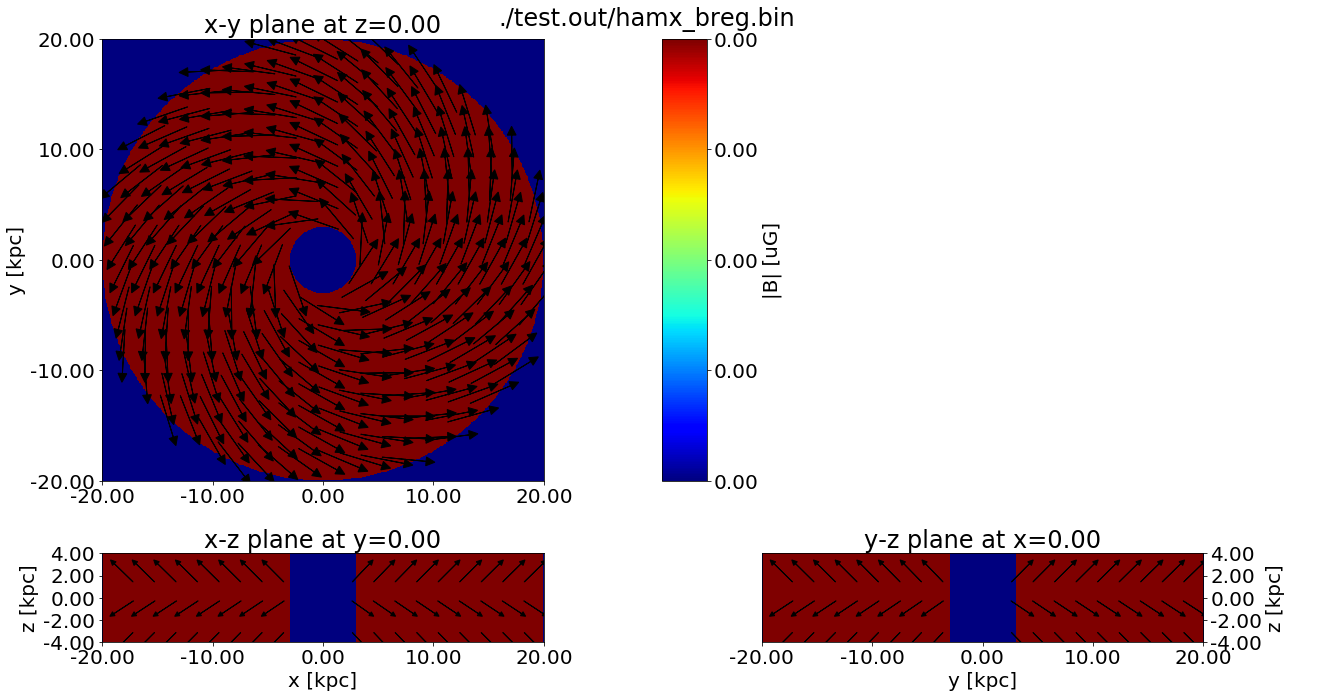

In [14]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
view_field(
    infile="./test.out/hamx_breg.bin",
    dtype='double',
    Ndims=[512,512,64],  # The dimensions, as given to hammurabi above
    Ldims=[40,40,8],     # The physical dimensions to display on the axis
    origin=[20,20,4],    # The location of the origin in these units
    #crange=[0,2e-6],        # The color scale's min and max
    bscale=0.05,         # The maximum length of the arrow in units of the plot size
    bskip=25,             # How many bins to skip between arrows.
    font=20
)


{'origin': [20, 20, 4], 'slices': [32, 256, 256], 'xrange': None, 'bskip': 25, 'scalar': False, 'bcolor': 'k', 'font': 20, 'unit': '[kpc]', 'fcodeB': '{:.2f}', 'yrange': None, 'title': None, 'label': '|B| [uG]', 'Ldims': [40, 40, 8], 'dtype': 'float', 'crange': None, 'infile': './ham.out/breg.bin', 'norm': 1.0, 'outfile': None, 'Ndims': [512, 512, 64], 'cmap': 'jet', 'figsize': None, 'bconst': False, 'bscale': 0.05, 'zrange': None, 'fcodeL': '{:.2f}'}


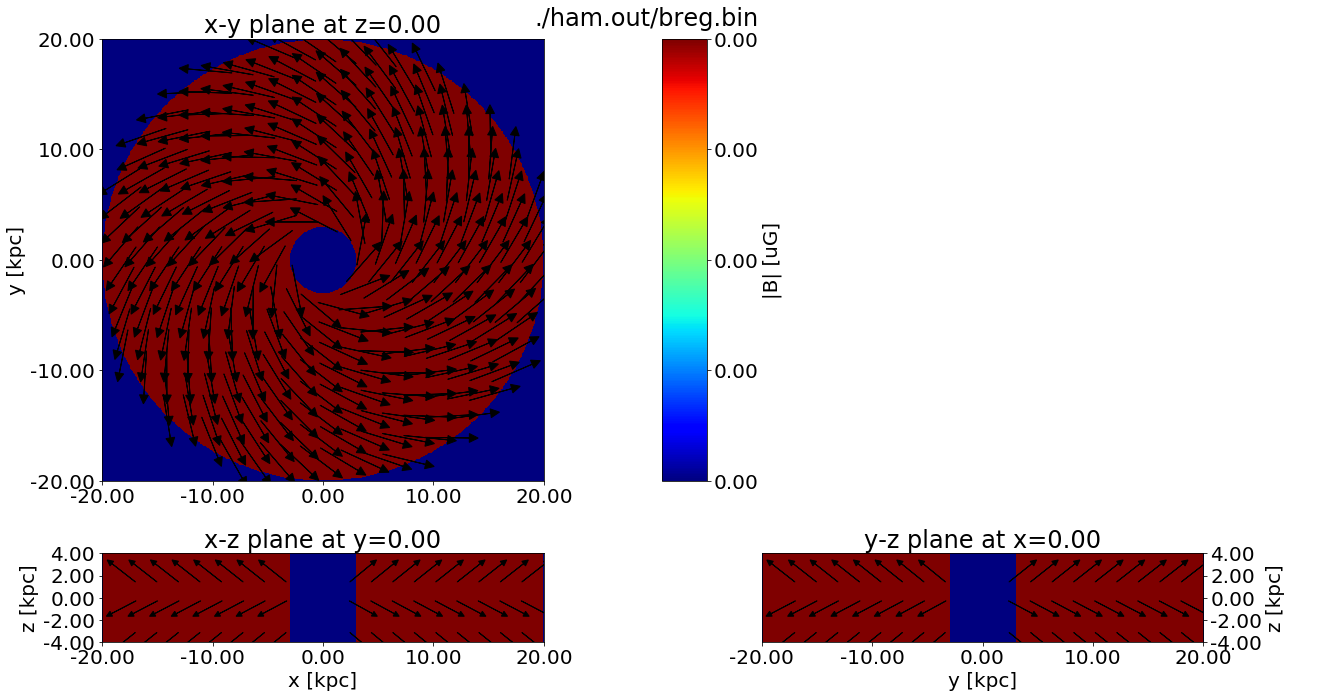

In [15]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
view_field(
    infile="./ham.out/breg.bin",
    dtype='float',
    Ndims=[512,512,64],  # The dimensions, as given to hammurabi above
    Ldims=[40,40,8],     # The physical dimensions to display on the axis
    origin=[20,20,4],    # The location of the origin in these units
    #crange=[0,1e-6],        # The color scale's min and max
    bscale=0.05,         # The maximum length of the arrow in units of the plot size
    bskip=25,             # How many bins to skip between arrows.
    font=20
)

{'origin': [20, 20, 4], 'slices': [100, 100, 100], 'xrange': None, 'bskip': 25, 'scalar': False, 'bcolor': 'k', 'font': 20, 'unit': '[kpc]', 'fcodeB': '{:.2f}', 'yrange': None, 'title': None, 'label': '|B| [uG]', 'Ldims': [40, 40, 8], 'dtype': 'double', 'crange': None, 'infile': '../../../hammurabi/hammurabi/unit_test/inputs/box_radio_loops.bin', 'norm': 1.0, 'outfile': None, 'Ndims': [200, 200, 200], 'cmap': 'jet', 'figsize': None, 'bconst': False, 'bscale': 0.05, 'zrange': None, 'fcodeL': '{:.2f}'}


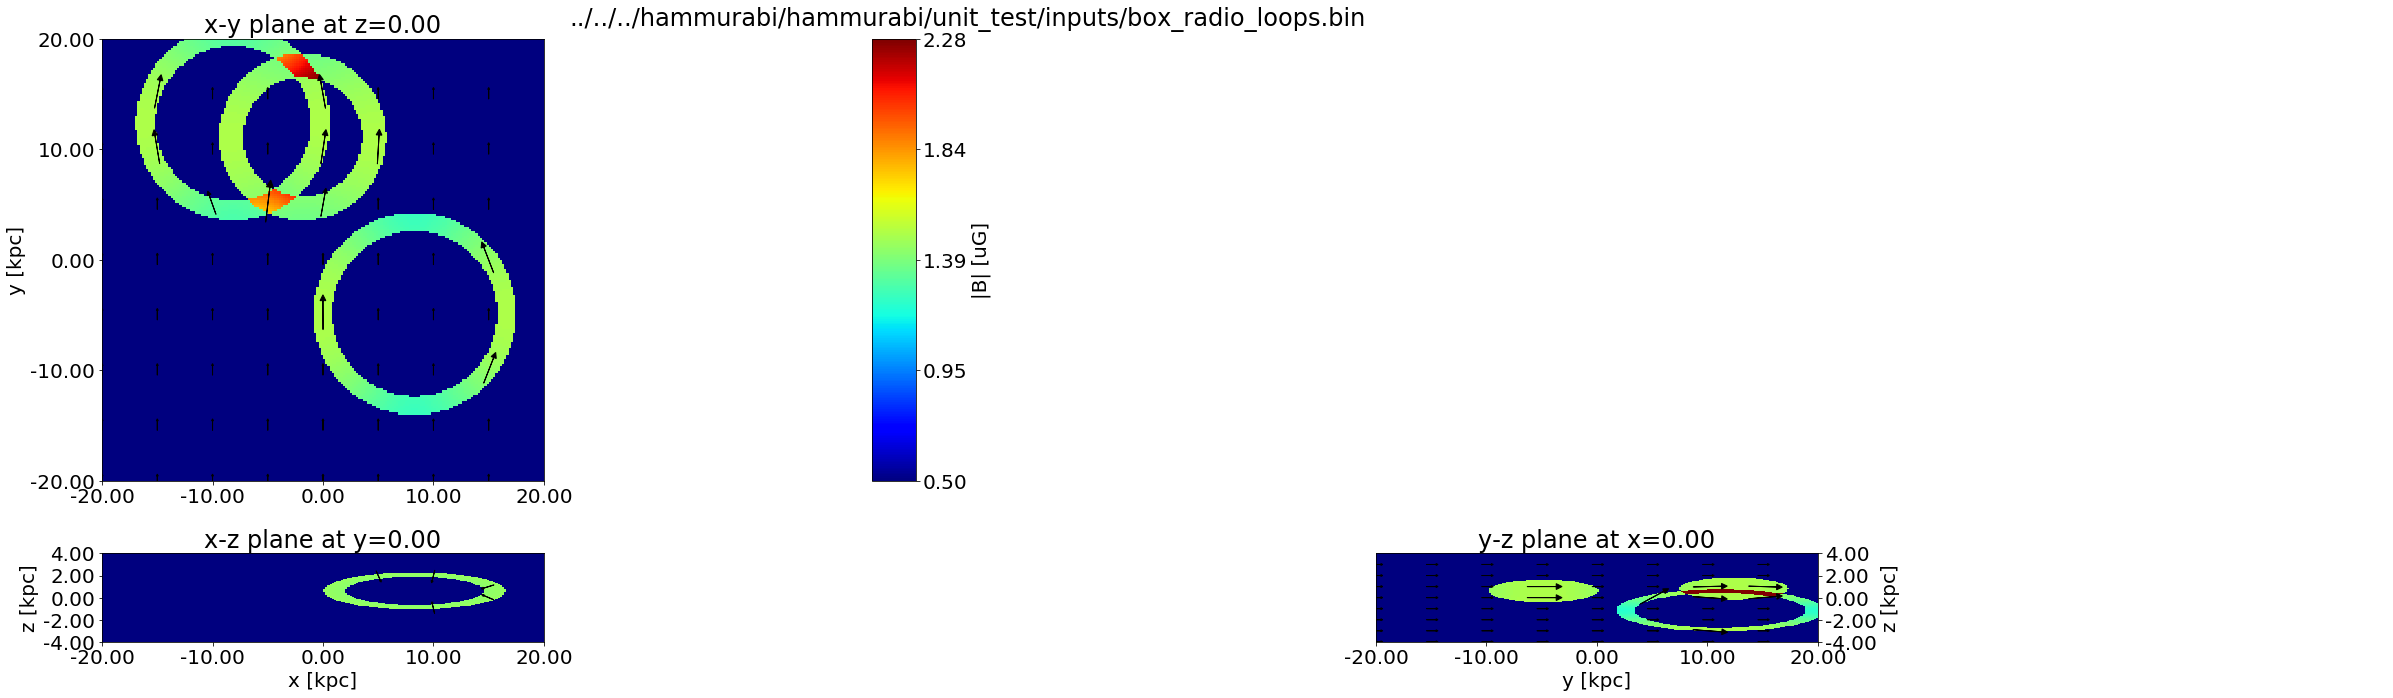

In [16]:
matplotlib.rcParams['figure.figsize'] = (40.0, 10.0)
view_field(
    infile="../../../hammurabi/hammurabi/unit_test/inputs/box_radio_loops.bin",
    dtype='double',
    Ndims=[200,200,200],  # The dimensions, as given to hammurabi above
    Ldims=[40,40,8],     # The physical dimensions to display on the axis
    origin=[20,20,4],    # The location of the origin in these units
    #crange=[0,1e-6],        # The color scale's min and max
    bscale=0.05,         # The maximum length of the arrow in units of the plot size
    bskip=25,             # How many bins to skip between arrows.
    font=20
)

In [ ]:
#from utils import read_box
#from view_field import get_slices
#from matplotlib import gridspec
#infile = "./test.out/hamx_breg.bin"
#infile = "./ham.out/breg.bin"
#box = read_box(infile,(512,512,64,3),dtype='double')
#thing = get_slices(box,{'slices':[32,256,256]})
#fig = plt.figure()
#axes = fig.add_subplot()
#axes.imshow(thing[1])
#print thing[0]
#gs = gridspec.GridSpec(1,1)
#axes=[fig.add_subplot(gs[0])]
#ax = axes[0]
#im = ax.imshow(thing[0])

In [ ]:
#[['MagneticField','Regular','Jaffe','arm_pitch'],'value','11.5'], #11.5
#[['MagneticField','Regular','Jaffe','bar_a'],'value', '.1'], #5.0
#[['MagneticField','Regular','Jaffe','bar_b'],'value','.1'], #3.0 (b/a ratio)
#[['MagneticField','Regular','Jaffe','bar_phi0'],'value','45.0'], #45.0
#[['MagneticField','Regular','Jaffe','r_peak'],'value','0'], #0,-1
#[['MagneticField','Regular','Jaffe','arm_amp1'],'value','2'], #2
#[['MagneticField','Regular','Jaffe','arm_amp2'],'value','0.133'], #0.133
#[['MagneticField','Regular','Jaffe','arm_amp3'],'value','-3.78'], #-3.78
#[['MagneticField','Regular','Jaffe','arm_amp4'],'value','0.32'], #0.32
#[['MagneticField','Regular','Jaffe','bss'],'cue','1'],
#[['MagneticField','Regular','Jaffe','quadruple'],'cue','1'], 
#[['MagneticField','Regular','Jaffe','ring'],'cue','1'],
#[['MagneticField','Regular','Jaffe','bar'],'cue','0'],
#[['MagneticField','Regular','WMAP','b0'],'6'], #1.2
#[['MagneticField','Regular','WMAP','psi0'],'35.0'], #27.0
#[['MagneticField','Regular','WMAP','psi1'],'0.9'], #0.9
#[['MagneticField','Regular','WMAP','chi0'],'25.0'], #25.0

In [8]:
print hamx_maps['Sync']['I']

[18572802.29617957 18572802.29617957 18572802.29617957 ...
 18572802.29617957 18572802.29617957 18572802.29617957]
